In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
train=pd.read_csv("titanic/titanic.csv")
train["sex"] = train["sex"].replace(["female"], 1)
train["sex"] = train["sex"].replace(["male"], 0)

Survived females: 0.7274678111587983
Survived males: 0.19098457888493475


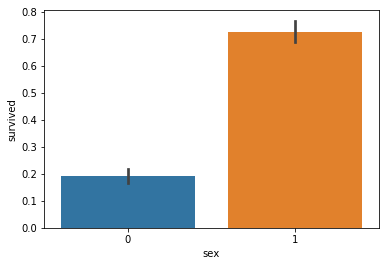

In [4]:
sns.barplot(x="sex", y="survived", data=train)
print("Survived females:", train["survived"][train["sex"] == 1].value_counts(normalize=True)[1])
print("Survived males:", train["survived"][train["sex"] == 0].value_counts(normalize=True)[1])

In [5]:
#Add Family_size feature

train["Family_size"] = train["sibsp"] + train["parch"]
#test["Family_size"] = test["sibsp"] + test["parch"]

In [6]:
train["Fname"] = train.name.apply(lambda x: x.split(",")[0])
#test["Fname"] = test.name.apply(lambda x: x.split(",")[0])

In [7]:
dead_train = train[train["survived"] == 0]
fname_ticket = dead_train[(dead_train["sex"] == 1) & (dead_train["Family_size"] >= 1)][["Fname", "ticket"]]
train["dead_family"] = np.where(train["Fname"].isin(fname_ticket["Fname"]) & train["ticket"].isin(fname_ticket["ticket"]) & ((train["age"] >=1) | train.age.isnull()), 1, 0)
#test["dead_family"] = np.where(test["Fname"].isin(fname_ticket["Fname"]) & test["ticket"].isin(fname_ticket["ticket"]) & ((test["age"] >=1) | test.age.isnull()), 1, 0)

In [8]:
live_train = train[train["survived"] == 1]
live_fname_ticket = live_train[(live_train["sex"] == 0) & (live_train["Family_size"] >= 1) & ((live_train["age"] >= 18) | (live_train["age"].isnull()))][["Fname", "ticket"]]
train["live_family"] = np.where(train["Fname"].isin(live_fname_ticket["Fname"]) & train["ticket"].isin(live_fname_ticket["ticket"]), 1, 0)
#test["live_family"] = np.where(test["Fname"].isin(live_fname_ticket["Fname"]) & test["ticket"].isin(live_fname_ticket["ticket"]), 1, 0)

In [9]:
dead_man_fname_ticket = train[(train["Family_size"] >= 1) & (train["sex"] == 0) & (train["survived"] == 0) & (train["dead_family"] == 0)][["Fname", "ticket"]]
train["deadfamily_man"] = np.where(train["Fname"].isin(dead_man_fname_ticket["Fname"]) & train["ticket"].isin(dead_man_fname_ticket["ticket"]) & (train.sex == 0), 1, 0)
train["deadfamily_woman"] = np.where(train["Fname"].isin(dead_man_fname_ticket["Fname"]) & train["ticket"].isin(dead_man_fname_ticket["ticket"]) & (train.sex == 1), 1, 0)
#test["deadfamily_man"] = np.where(test["Fname"].isin(dead_man_fname_ticket["Fname"]) & test["ticket"].isin(dead_man_fname_ticket["ticket"]) & (test.sex == 0), 1, 0)
#test["deadfamily_woman"] = np.where(test["Fname"].isin(dead_man_fname_ticket["Fname"]) & test["ticket"].isin(dead_man_fname_ticket["ticket"]) & (test.sex == 1), 1, 0)
train.loc[(train["dead_family"] == 0) & (train["live_family"] == 0) & (train["deadfamily_man"] == 0) & (train["deadfamily_woman"] == 0) & (train["Family_size"] >= 1) & (train["sex"] == 0), "deadfamily_man"] = 1
train.loc[(train["dead_family"] == 0) & (train["live_family"] == 0) & (train["deadfamily_man"] == 0) & (train["deadfamily_woman"] == 0) & (train["Family_size"] >= 1) & (train["sex"] == 1), "deadfamily_woman"] = 1
#test.loc[(test["dead_family"] == 0) & (test["live_family"] == 0) & (test["deadfamily_man"] == 0) & (test["deadfamily_woman"] == 0) & (test["Family_size"] >= 1) & (test["sex"] == 0), "deadfamily_man"] = 1
#test.loc[(test["dead_family"] == 0) & (test["live_family"] == 0) & (test["deadfamily_man"] == 0) & (test["deadfamily_woman"] == 0) & (test["Family_size"] >= 1) & (test["sex"] == 1), "deadfamily_woman"] = 1

In [12]:
grp_tk = train.drop(["survived"], axis=1).groupby(["ticket"])
tickets = []
for grp, grp_train in grp_tk:
    ticket_flag = True
    if len(grp_train) != 1:
        for i in range(len(grp_train) - 1):
            if grp_train.iloc[i]["Fname"] != grp_train.iloc[i+1]["Fname"]:
                ticket_flag = False
    if ticket_flag == False:
        tickets.append(grp)
train.loc[(train.ticket.isin(tickets)) & (train.Family_size == 0) & (train.sex == 0), "deadfamily_man"] = 1
train.loc[(train.ticket.isin(tickets)) & (train.Family_size == 0) & (train.sex == 1), "deadfamily_woman"] = 1
#test.loc[(test.ticket.isin(tickets)) & (test.Family_size == 0) & (test.sex == 0), "deadfamily_man"] = 1
#test.loc[(test.ticket.isin(tickets)) & (test.Family_size == 0) & (test.sex == 1), "deadfamily_woman"] = 1

In [13]:
#test = test.fillna({"fare": test[test["pclass"] == 3]["fare"].mean()})
#test["fare"] = test["fare"].astype(int)
train = train.drop(["ticket", "cabin", "embarked", "Fname"], axis=1)
#test = test.drop(["ticket", "cabin", "embarked", "Fname"], axis=1)

In [1]:
"""
train_dummies_sex = pd.get_dummies(train["sex"])
test_dummies_sex = pd.get_dummies(test["sex"])
train = pd.concat([train, train_dummies_sex], axis=1)
test = pd.concat([test, test_dummies_sex], axis=1)
train = train.drop(["sex"], axis=1)
test = test.drop(["sex"], axis=1)"""

'\ntrain_dummies_sex = pd.get_dummies(train["sex"])\ntest_dummies_sex = pd.get_dummies(test["sex"])\ntrain = pd.concat([train, train_dummies_sex], axis=1)\ntest = pd.concat([test, test_dummies_sex], axis=1)\ntrain = train.drop(["sex"], axis=1)\ntest = test.drop(["sex"], axis=1)'

In [14]:
train_name = train.name.str.extract("([a-zA-Z]+)\.")
#test_name = test.name.str.extract("([a-zA-Z]+)\.")
train_name["Title"] = train.name.str.extract("([a-zA-Z]+)\.")
#test_name["Title"] = test.name.str.extract("([a-zA-Z]+)\.")
 
train_name = train_name.drop([0], axis=1)
#test_name = test_name.drop([0], axis=1)
 
train_name["Title"] = train_name["Title"].replace(["Mlle", "Ms"], "Miss")
train_name["Title"] = train_name["Title"].replace(["Mme"], "Mrs")
train_name["Title"] = train_name["Title"].replace(["Countess", "Sir", "Lady", "Don"], "Royal")
train_name["Title"] = train_name["Title"].replace(["Dr", "Rev", "Col", "Major", "Jonkheer", "Capt","Dona"], "Rare")
 
#test_name["Title"] = test_name["Title"].replace(["Ms"], "Miss")
#test_name["Title"] = test_name["Title"].replace(["Dona"], "Mrs")
#test_name["Title"] = test_name["Title"].replace(["Dr", "Rev", "Col"], "Rare")
 
train_name["Title"] = train_name["Title"].replace(["Mr"], 1)
train_name["Title"] = train_name["Title"].replace(["Miss"], 2)
train_name["Title"] = train_name["Title"].replace(["Mrs"], 3)
train_name["Title"] = train_name["Title"].replace(["Master"], 4)
train_name["Title"] = train_name["Title"].replace(["Royal"], 5)
train_name["Title"] = train_name["Title"].replace(["Rare"], 6)

 
#test_name["Title"] = test_name["Title"].replace(["Mr"], 1)
#test_name["Title"] = test_name["Title"].replace(["Miss"], 2)
#test_name["Title"] = test_name["Title"].replace(["Mrs"], 3)
#test_name["Title"] = test_name["Title"].replace(["Master"], 4)
#test_name["Title"] = test_name["Title"].replace(["Rare"], 6)
 
train["Title"] = train_name["Title"]
#test["Title"] = test_name["Title"]
 
train = train.drop(["name"], axis=1)
#test = test.drop(["name"], axis=1)

In [15]:
train = train.drop(["boat", "body", "home.dest"], axis=1)
#test = test.drop(["boat", "body", "home.dest"], axis=1)

In [16]:
train = train.drop(["sibsp", "parch"], axis=1)
#test = test.drop(["sibsp", "parch"], axis=1)

In [17]:
data = [train]
for dataset in data:
    mean = train["age"].mean()
    std = train["age"].std()
    is_null = dataset["age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["age"] = age_slice
    #dataset["age"] = train["age"].astype(int)

In [18]:
train["fare"][np.isnan(train["fare"])]=train["fare"].mean()

C:\Users\OSHIN DUTTA\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 11 columns):
pclass              1309 non-null int64
survived            1309 non-null int64
sex                 1309 non-null int64
age                 1309 non-null float64
fare                1309 non-null float64
Family_size         1309 non-null int64
dead_family         1309 non-null int32
live_family         1309 non-null int32
deadfamily_man      1309 non-null int32
deadfamily_woman    1309 non-null int32
Title               1309 non-null int64
dtypes: float64(2), int32(4), int64(5)
memory usage: 92.1 KB


In [20]:
train.loc[train["age"] <= 15, "AgeBin"] = 0
train.loc[(train["age"] > 15) & (train["age"] <= 30), "AgeBin"] = 1
train.loc[(train["age"] > 30) & (train["age"] <= 49), "AgeBin"] = 2
train.loc[(train["age"] > 49) & (train["age"] < 80), "AgeBin"] = 3
train.loc[train["age"] >= 80, "AgeBin"] = 4
#test.loc[test["age"] <= 15, "AgeBin"] = 0
#test.loc[(test["age"] > 15) & (test["age"] <= 30), "AgeBin"] = 1
#test.loc[(test["age"] > 30) & (test["age"] <= 49), "AgeBin"] = 2
#test.loc[(test["age"] > 49) & (test["age"] < 80), "AgeBin"] = 3
#test.loc[test["age"] >= 80, "AgeBin"] = 4

In [23]:

pd.qcut(train.drop(["survived"], axis=1)["fare"], 5).head(10)

0    (41.579, 512.329]
1    (41.579, 512.329]
2    (41.579, 512.329]
3    (41.579, 512.329]
4    (41.579, 512.329]
5     (21.679, 41.579]
6    (41.579, 512.329]
7      (-0.001, 7.854]
8    (41.579, 512.329]
9    (41.579, 512.329]
Name: fare, dtype: category
Categories (5, interval[float64]): [(-0.001, 7.854] < (7.854, 10.5] < (10.5, 21.679] < (21.679, 41.579] < (41.579, 512.329]]

In [24]:
train.loc[train["fare"] <= 7.854, "FareBin"] = 0
train.loc[(train["fare"] > 7.854) & (train["fare"] <= 10.5), "FareBin"] = 1
train.loc[(train["fare"] > 10.5) & (train["fare"] <= 21.558), "FareBin"] = 2
train.loc[(train["fare"] > 21.558) & (train["fare"] <= 41.579), "FareBin"] = 3
train.loc[train["fare"] > 41.579, "FareBin"] = 4
#test.loc[test["fare"] <= 7.854, "FareBin"] = 0
#test.loc[(test["fare"] > 7.854) & (test["fare"] <= 10.5), "FareBin"] = 1
#test.loc[(test["fare"] > 10.5) & (test["fare"] <= 21.558), "FareBin"] = 2
#test.loc[(test["fare"] > 21.558) & (test["fare"] <= 41.579), "FareBin"] = 3
#test.loc[test["fare"] > 41.579, "FareBin"] = 4

In [25]:
train = train.drop(["age", "fare"], axis=1)
#test = test.drop(["age", "fare"], axis=1)

In [26]:

train.head(10)

,pclass,survived,sex,Family_size,dead_family,live_family,deadfamily_man,deadfamily_woman,Title,AgeBin,FareBin
0,1,1,1,0,0,0,0,1,2,1.0,4.0
1,1,1,0,3,0,0,1,0,4,0.0,4.0
2,1,0,1,3,1,0,0,0,2,0.0,4.0
3,1,0,0,3,1,0,0,0,1,1.0,4.0
4,1,0,1,3,1,0,0,0,3,1.0,4.0
5,1,1,0,0,0,0,0,0,1,2.0,3.0
6,1,1,1,1,0,0,0,1,2,3.0,4.0
7,1,0,0,0,0,0,0,0,1,2.0,0.0
8,1,1,1,2,0,0,0,1,3,3.0,4.0
9,1,0,0,0,0,0,0,0,1,3.0,4.0


In [61]:
""""trainx=train.drop(["survived"], axis=1)
#testx=test.drop(["survived"],axis=1)
X=trainx.iloc[:,0:2].values
X_test=testx.iloc[:,0:2].values
test["pclass"].describe"""


<bound method NDFrame.describe of 0      3
1      3
2      3
3      3
4      3
5      3
6      3
7      3
8      3
9      3
10     3
11     3
12     3
13     3
14     3
15     3
16     3
17     3
18     3
19     3
20     3
21     3
22     3
23     3
24     3
25     3
26     3
27     3
28     3
29     3
      ..
389    3
390    3
391    3
392    3
393    3
394    3
395    3
396    3
397    3
398    3
399    3
400    3
401    3
402    3
403    3
404    3
405    3
406    3
407    3
408    3
409    3
410    3
411    3
412    3
413    3
414    3
415    3
416    3
417    3
418    3
Name: pclass, Length: 419, dtype: int64>

In [27]:
y = train["survived"]
#train_x, val_x, train_y, val_y = train_test_split(X, y, test_size=0.22, random_state=0)
train_x, test_x, train_y, test_y = train_test_split(train.drop(["survived"], axis=1), y, test_size=0.22, random_state=0)
clf = SVC(C=1, probability=True)
score = cross_val_score(clf,train_x, train_y, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
clf.fit(train_x,train_y)
#clf.score(val_x, val_y)
score

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


0.8766616153334352

In [28]:
test_x.describe

<bound method NDFrame.describe of       pclass  sex  Family_size  dead_family  live_family  deadfamily_man  \
1139       3    0            0            0            0               0   
533        2    1            1            0            0               0   
459        2    0            1            0            0               1   
1150       3    0            0            0            0               0   
393        2    0            0            0            0               1   
1189       3    1            2            0            0               0   
5          1    0            0            0            0               0   
231        1    0            0            0            0               0   
330        2    0            0            0            0               0   
887        3    0            0            0            0               0   
531        2    0            0            0            0               0   
790        3    0            2            0           

In [41]:
svc_grid = GridSearchCV(SVC(), {"C": [i for i in range(1, 101)]}, cv=4)
svc_grid.fit(train_x, train_y)
svc_grid.best_params_

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

{'C': 2}

In [42]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,train_scores_mean + train_scores_std, alpha=0.1,color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",label="Cross-validation score")
    plt.legend(loc="best") 
    return plt

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

<module 'matplotlib.pyplot' from 'C:\\Users\\OSHIN DUTTA\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

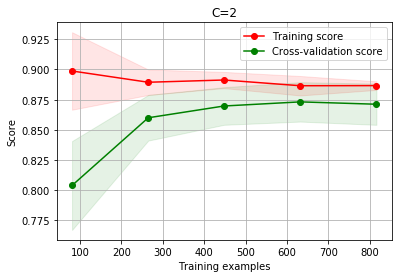

In [44]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(SVC(C=2), "C=2", train_x, train_y, cv=cv)


C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

<module 'matplotlib.pyplot' from 'C:\\Users\\OSHIN DUTTA\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

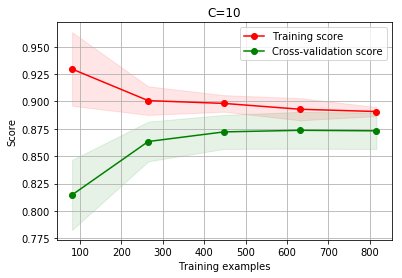

In [45]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(SVC(C=10), "C=10", train_x,train_y, cv=cv)

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

<module 'matplotlib.pyplot' from 'C:\\Users\\OSHIN DUTTA\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

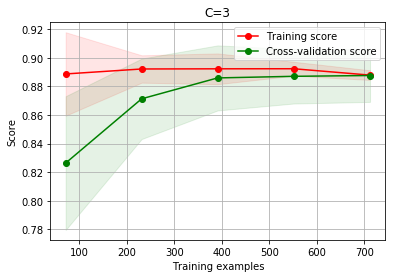

In [34]:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(SVC(C=3), "C=3", train.drop(["survived","Title"], axis=1), y, cv=cv)

In [50]:
clf = SVC(C=2, probability=True)
clf.fit(train_x, train_y)
sub_y = clf.predict(test_x)

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [51]:
c_y=test_y

In [52]:
(sub_y==c_y).mean()

0.8645833333333334

In [53]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
clf_svm = SVC(C=2, probability=True)
predictions = cross_val_predict(clf_svm, train_x,train_y , cv=10)
cnf_matrix=confusion_matrix(train_y, predictions)


C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\

In [54]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[576  50]
 [ 71 324]]


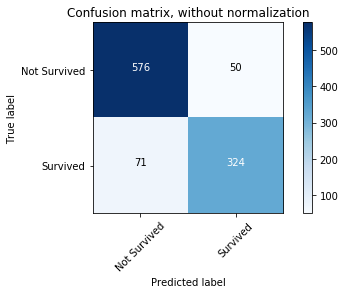

In [55]:
class_names = ['Not Survived', 'Survived']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

In [56]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(train_y, predictions))
print("Recall:",recall_score(train_y, predictions))

Precision: 0.8663101604278075
Recall: 0.8202531645569621


In [57]:
from sklearn.metrics import f1_score
f1_score(train_y, predictions)

0.8426527958387516

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Text(0.5, 1.0, 'Support Vector Machines')

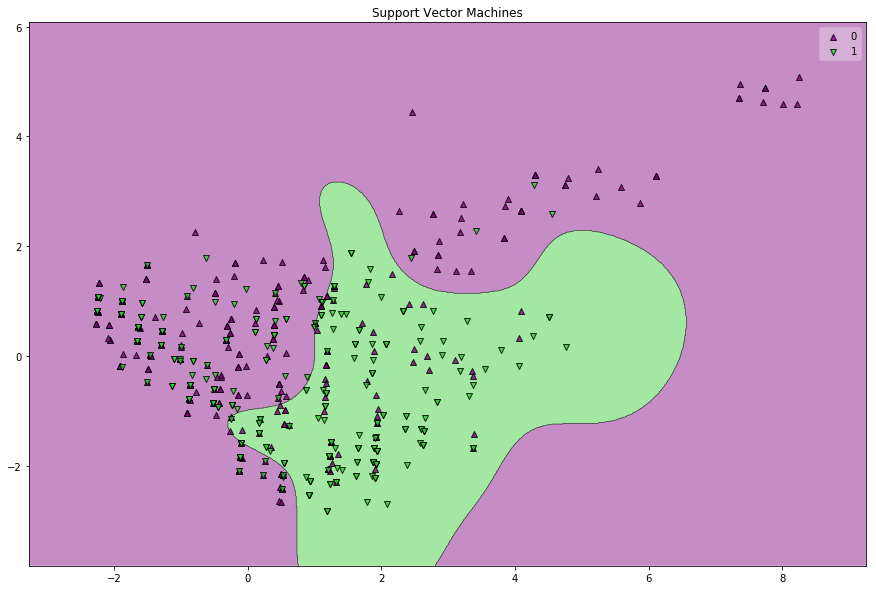

In [58]:
#visualization
from sklearn.decomposition import PCA
from mlxtend.plotting import plot_decision_regions
X_train_reduced = PCA(n_components = 2).fit_transform(train_x)
t = np.array(train_y)
t = t.astype(np.integer)
clf_svm = SVC(C=10, probability=True)
clf_svm.fit(X_train_reduced,t)
plt.figure(figsize = [15,10])
plot_decision_regions(X_train_reduced, t, clf = clf_svm, hide_spines = False, colors = 'purple,limegreen',
                      markers = ['^','v'])
plt.title('Support Vector Machines')

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
clf_lr = LogisticRegression()
linear_svc = LinearSVC()
clf_nbayes = GaussianNB()
Classifiers = ['LogisticRegression','Linear SVM','naive bayes']
scores = []
models = [clf_lr, linear_svc, clf_nbayes]
for model in models:
    score = cross_val_score(model, train_x, train_y, scoring = 'accuracy', cv = 10, n_jobs = -1).mean()
    scores.append(score)

In [60]:
mode = pd.DataFrame(scores, index = Classifiers, columns = ['score']).sort_values(by = 'score',
             ascending = False)
mode

,score
Linear SVM,0.865799
LogisticRegression,0.864819
naive bayes,0.613971


In [61]:
clf_nbayes.fit( train_x, train_y)
y_pred_nbayes=clf_nbayes.predict(test_x)
(y_pred_nbayes==c_y).mean()

0.5416666666666666

In [62]:
clf_lr.fit( train_x, train_y)
y_pred_lr=clf_lr.predict(test_x)
(y_pred_lr==c_y).mean()

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.84375

In [63]:
linear_svc.fit( train_x, train_y)
y_pred_lsvc=linear_svc.predict(test_x)
(y_pred_lsvc==c_y).mean()

C:\Users\OSHIN DUTTA\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.84375